# Dataset 

This notebook will provide a python class for the histology dataset. The histology class will be capable of automatic data augmentation. 

In [1]:
import torch # The script uses pytorch to automatically convert the image data (numpy) to pytorch 

# Import imgaug to enable data augmentation for the dataset class  
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage # 

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

We will now define the HistologyDataset class

In [2]:
class HistologyDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params # Assign augmentation parameters to corresponding class attribute
    
    # Function extract_files will never accesses any class attributes. 
    # Therefore, there is no need to accept the self argument   
    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for specimen in root.glob("*"):    # Iterate across the histology specimens
            slice_path = specimen/"data"   # Get the image slices for the current specimen the data are saved in the 'data folder'
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files
    
    # Helper function which replaces img path with label path   
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        
        # Update internal seed of imgaug
        
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)
        #####################################################
        
        # During data augmentation, it is important to apply the same augmentation steps to both img and label data
        # The imgaug package is capable of doing this automatically. For this, we need to generate a mask object, 
        # which will then be transformed together with the image data
        
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr() 
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
        
    def __getitem__(self, idx):
        """
        Given an index, return the (augmented) slice and corresponding (augmented) mask
        Add another dimension for pytorch
        """
        
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float, as PyTorch needs this for training
        mask = np.load(mask_path)
        
        # Check if augmentation pipeline exists
        # If so, call augmentation function
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        # Note that PyTorch expects the input of shape BxCxHxW, where B corresponds to the batch size, C to the channels, H to the height, and W to Width.
        # As our data is of shape (HxWxC) we need to manually transpose the data to be of CxHxW shape.
        # To fulfill PyTorch requirements, a dummy dimension is added to the mask array (1xHxW) 
        # The batch dimension is later added by the data loader
        
        return np.transpose(slice, axes = (2,0,1)), np.expand_dims(mask, 0)
        

The HistologyDataset class will be saved in the dataset.py file for later use.  

Now, we will define the data augmentation steps for the training. This will be done using the imgaug sequential function. 

Histology data can be heavily augmented, as they do not have a distinct direction or color scale.

Hence, data augmentation will entail random changes of contrast, image intensity, random flips in all directions, random affine transformation with 12 DOF, and random elastic transformations.

In [8]:
seq = iaa.Sequential([
        iaa.LinearContrast((0.5, 1.5)), # Random Change of contrast
        iaa.Multiply((0.5, 1.5), per_channel=0.2), # Random Change of image intensity, in 20% of augmentations only for one random channel
        iaa.Fliplr(0.5), # Random Left Right Flip
        iaa.Flipud(0.5), # Random Up Down Flip
        iaa.Affine(scale=(0.90, 1.10), # Random Scaling of the image
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Random Translation 
                        rotate=(-45, 45),# Random rotation up to 45deg
                        shear=(-15, 15)),  # Random shear
        iaa.ElasticTransformation()  # Random elastic deformations to locally displace some pixels
        ])

In [9]:
# Create the dataset object and load it with predefined iaa sequenatial
path = Path('preprocessed/train/')
dataset = HistologyDataset(path, seq)

For visualization purposes, the normalization step of the preprocessed data needs to be reversed. This will be done using the following function 'un_standardize', which uses the channel-wise sample mean and standard deviations, to reverse the channel-wise z-transformation. 

Without this un_standardize operation, it will be hard to see the desired structures in the images, as plt.imshow expects float data to range between 0 and 1  

In [10]:
# Per Channel means and stand deviations to 'un-normalize' the image data
means = np.array([0.53955701, 0.38888616, 0.56235658])
stds = np.array([0.21415865, 0.2144178,  0.16906027])

def un_standardize(img, means, stds):
    """
    Helper Function to reverse the channel wise z-transformation of the data preprocessing
    """
    
    # Create empty array
    img_un_normalized = np.zeros_like(img)
    
    # Go through cannels and reverse z-transform
    for i in range(img.shape[-1]):
        img_un_normalized[...,i] = stds[...,i] * img[...,i] + means[...,i]

    # Clip data between 0 and 1 to prevent matplotlib errors
    return np.clip(img_un_normalized, 0, 1)

This function will be stored in the local functions.py file for future use. 

Now, the notebook will showcase the dataset class and the data augmentation functionality

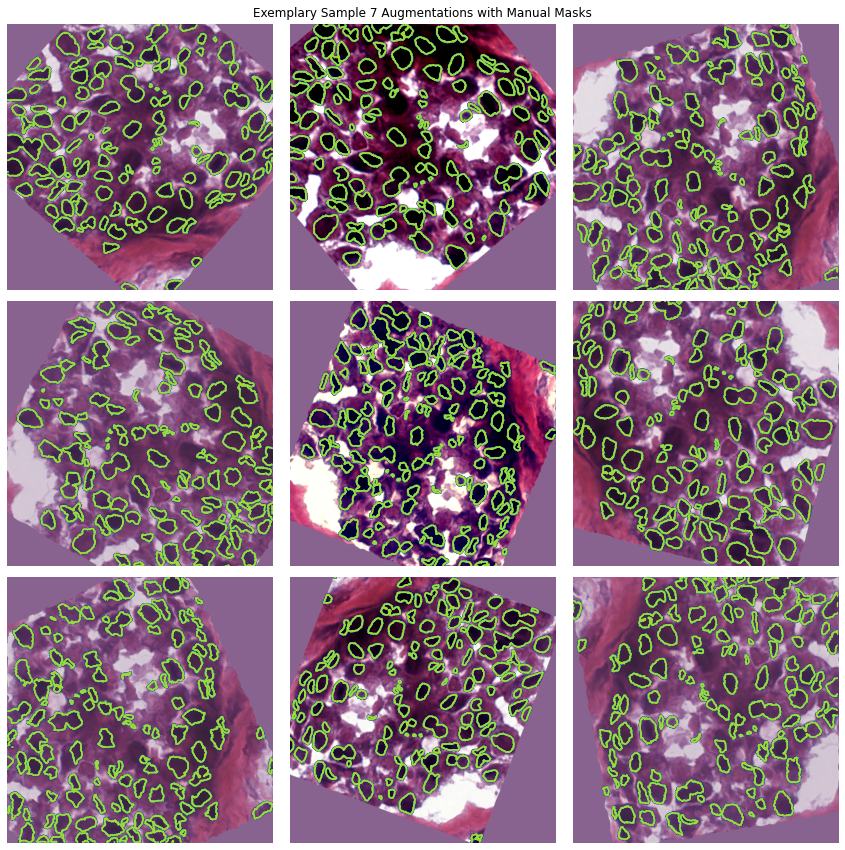

In [12]:
# Create a 3x3 matplot subplot structure 
fig, axis = plt.subplots(3, 3, figsize=(12, 12))

# Select a random number, representing a random tissue sample in our training dataset 
select_dataset = np.random.randint(low = 0, high = len(dataset) -1) # Select random integer dataset 

# Loop through all subplots 
for i in range(3):
    for j in range(3):
        # Load a predefined random dataset, with random data augmentation
        img, mask = dataset[select_dataset]
        
        # transpose data from pytorch to matplotlib convention for color images
        img = img.transpose((1,2,0))
        
        # un standardize the data using sample means and stds
        img_un_normalized = un_standardize(img, means, stds)
        
        # Plot the data, overlaid with mask contour map
        axis[i][j].imshow(img_un_normalized)
        axis[i][j].contour(mask[0])
        axis[i][j].axis("off")

        
fig.suptitle('Exemplary Sample {} Augmentations with Manual Masks'.format(int(select_dataset)))
plt.tight_layout()